# Import Packages

- `time` - datetime - ability to get current time for logs
- `math` - basic mathematical functions (as logarithm etc.))
- `numpy` - for mathematical,and numerical calculations
- `scipy` - for metrics evaluation calculations
- `pandas` - for work with large data structures
- `scikit` - all important machine learning (and statistical) algorithms used for training the models
- `matplotlib` - for plotting the charts
- `seaborn` - for statistical visualisations
- `xgboost` - gradient boosting used for training the models
- `category_encoders` - for category type transformation
- `ia_pkg` - for combined function used in this notebook

In [1]:
import pandas as pd
import numpy as np
import time
import datetime

import ia_pkg

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, HTML, Markdown

from numpy import sqrt
from numpy import argmax
from numpy import arange

from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Checking used library version
ia_pkg.pkg_version()

 Package version check
numpy: 1.19.2
pandas: 1.1.3
sklearn: 0.23.2
matplotlib: 3.3.2
seaborn: 0.11.0
scipy: 1.5.2
xgboost: 0.90
category_encoders : 2.2.2



# Import Data

In [3]:
#Import data from CSV

data = pd.read_csv('traintest_base_v2.csv',index_col='Ids')
alerts = pd.read_csv('alerts_v3.csv')
target = pd.read_csv('D:\\Downloads\\danthon\\data_train.csv',index_col='Ids')
irr1 = pd.read_csv('D:\\Downloads\\danthon\\Irreg_Rhesa.csv',sep=';')
irr2 = pd.read_csv('irr_part2.csv')
print('Data loaded on', datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S'))

Data loaded on 2021-03-16 19:31:58


In [4]:
print(data.shape)
print(target.shape)

(85177, 10)
(71336, 1)


## Join base and target

In [5]:
data = pd.merge(data,target, how='left', on='Ids')

In [6]:
# masking row for modeling and kaggle submit
mask_dev =  data['train_test'] == 'train'
mask_submit = data['train_test'] == 'test'

In [7]:
# change label datatype to integer
data['target'] = np.where(data['Labels'] == True,1,
                         np.where(data['Labels'] == False,0,np.nan)).astype('int64')

## Initial check

In [8]:
#Running DataFrame optimizer to reduce memory usage
from ia_pkg.function import optimizer
data = optimizer(data)

Memory usage of dataframe is: 8.45 MB
Memory usage after optimization is: 6.42 MB
Decreased by 24.0%


In [9]:
#Remove rows with duplicated index
data=data[~data.index.duplicated(keep='first')]

In [10]:
print('Number of rows:',data.shape[0])
print('Number of columns:',data.shape[1])

Number of rows: 85177
Number of columns: 12


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85177 entries, 2e69e9384_2020-10-06_13 to 2e698d804_2020-11-25_19
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   train_test     85177 non-null  object 
 1   daytime        85177 non-null  object 
 2   weekofmonth    85177 non-null  object 
 3   isweekend      85177 non-null  uint8  
 4   isrushhour     85177 non-null  uint8  
 5   ispayday       85177 non-null  uint8  
 6   city_pred      85177 non-null  object 
 7   street_pred    80635 non-null  object 
 8   roadtype_pred  83273 non-null  float32
 9   highway_pred   1904 non-null   object 
 10  Labels         71336 non-null  object 
 11  target         85177 non-null  int64  
dtypes: float32(1), int64(1), object(7), uint8(3)
memory usage: 6.4+ MB


In [12]:
#change roadtype to category
data['roadtype_pred'] = data['roadtype_pred'].astype('str')

In [13]:
data.head()

,train_test,daytime,weekofmonth,isweekend,isrushhour,ispayday,city_pred,street_pred,roadtype_pred,highway_pred,Labels,target
Ids,,,,,,,,,,,,
2e69e9384_2020-10-06_13,train,noon,w_1,0,0,1,Depok,Sawangan Raya,7.0,NaN,True,1
2e6992c7c_2020-10-02_17,train,evening,w_1,0,1,1,Bekasi,Hankam Raya,2.0,NaN,True,1
2e69ef474_2020-09-13_19,train,evening,w_2,1,1,0,Depok,N6 Cinangka Raya,6.0,NaN,True,1
2e69c5fd4_2020-10-10_15,train,noon,w_2,1,0,0,Bogor,N9 Jalan Raya Pajajaran,6.0,NaN,True,1
2e6992134_2020-09-12_11,train,morning,w_2,1,0,0,Bekasi,Narogong Raya,7.0,NaN,True,1


## Metadata Definition

In [14]:
col_target = 'target'

cols_pred = list(data.columns[1:-2])

cols_pred_num = list(data[cols_pred].select_dtypes(include=np.number).columns)
cols_pred_cat = list(data[cols_pred].select_dtypes(include=np.object).columns)

print('List of numerical predictors:', len(cols_pred_num),'\n\n', data[cols_pred_num].dtypes)
print('\nList of categorical predictors: ', len(cols_pred_cat), '\n\n', data[cols_pred_cat].dtypes)

List of numerical predictors: 3 

 isweekend     uint8
isrushhour    uint8
ispayday      uint8
dtype: object

List of categorical predictors:  6 

 daytime          object
weekofmonth      object
city_pred        object
street_pred      object
roadtype_pred    object
highway_pred     object
dtype: object


# Data Exploration

Showing the statistical summary, could help us on preliminary investigation on dataset

In [15]:
data[mask_dev].describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
train_test,71336,1,train,71336,NaN,NaN,NaN,NaN,NaN,NaN,NaN
daytime,71336,4,evening,34797,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weekofmonth,71336,5,w_1,20199,NaN,NaN,NaN,NaN,NaN,NaN,NaN
isweekend,71336,NaN,NaN,NaN,0.361823,0.480531,0,0,0,1,1
isrushhour,71336,NaN,NaN,NaN,0.584922,0.492739,0,0,1,1,1
ispayday,71336,NaN,NaN,NaN,0.515812,0.499753,0,0,1,1,1
city_pred,71336,20,Bandung,22046,NaN,NaN,NaN,NaN,NaN,NaN,NaN
street_pred,67529,1426,Sawangan Raya,2451,NaN,NaN,NaN,NaN,NaN,NaN,NaN
roadtype_pred,71336,10,2.0,25552,NaN,NaN,NaN,NaN,NaN,NaN,NaN
highway_pred,1404,2,t,801,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
data[mask_submit].describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
train_test,13841,1,test,13841,NaN,NaN,NaN,NaN,NaN,NaN,NaN
daytime,13841,4,evening,6492,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weekofmonth,13841,2,w_4,11986,NaN,NaN,NaN,NaN,NaN,NaN,NaN
isweekend,13841,NaN,NaN,NaN,0.349108,0.476705,0,0,0,1,1
isrushhour,13841,NaN,NaN,NaN,0.519471,0.499639,0,0,1,1,1
ispayday,13841,NaN,NaN,NaN,0.893433,0.308574,0,1,1,1,1
city_pred,13841,20,Bekasi,4217,NaN,NaN,NaN,NaN,NaN,NaN,NaN
street_pred,13106,619,Cibarusah Raya,597,NaN,NaN,NaN,NaN,NaN,NaN,NaN
roadtype_pred,13841,9,2.0,5546,NaN,NaN,NaN,NaN,NaN,NaN,NaN
highway_pred,500,2,f,265,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Missing Value Check

In [17]:
# Investigate columns with null values
missingCol = data[mask_dev].isnull().sum()
print("There are", len(missingCol[missingCol != 0]),"columns with missing value")

There are 2 columns with missing value


In [18]:
# Investigate null rate of contained null columns
missingRate = []
try:
    for col in cols_pred:
        if data[mask_dev][col].isnull().any():
            missingRate.append({'Predictor' : col,
                       'Missing rate' : data[mask_dev][col].isnull().sum() / data[mask_dev].shape[0]})
    pd.DataFrame(missingRate).set_index('Predictor').sort_values('Missing rate',ascending=False)
except: print('no missing predictor')

## Outlier Check (IQR based)

In [19]:
from ia_pkg.function import cnt_outliers, replace_with_thresholds

# Check number of 1.5 IQR based outlier
try:
    cnt_outliers(data[mask_dev],cols_pred_num,plot=True)
except:
    print('no outlier detected')

## Predictor Distribution to Target

**Categorical predictor**

***

### daytime

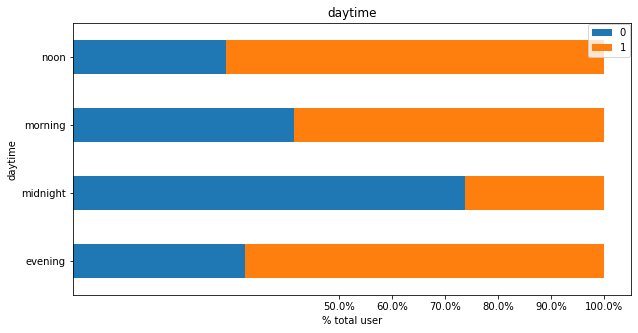

***

### weekofmonth

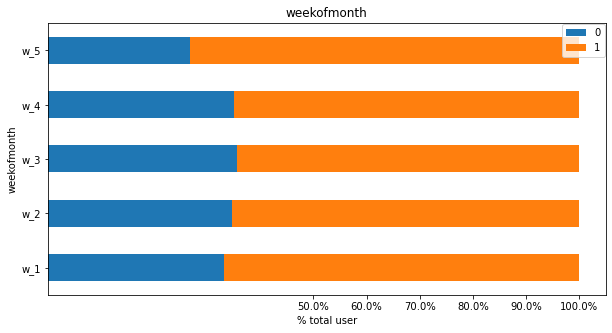

***

### city_pred

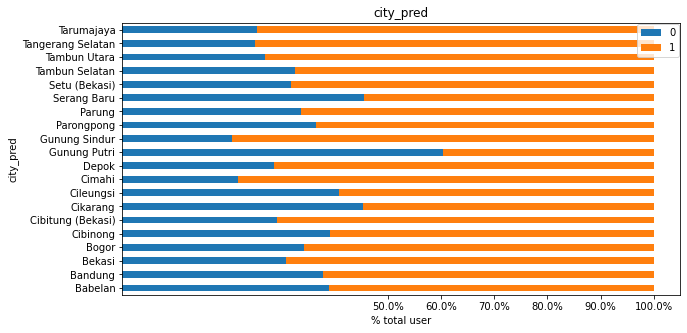

***

### street_pred

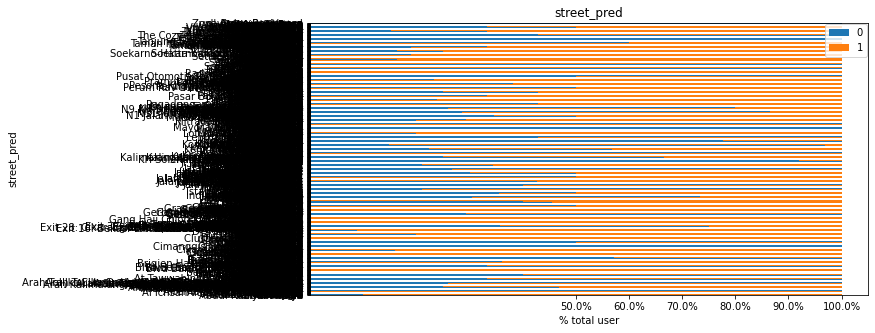

***

### roadtype_pred

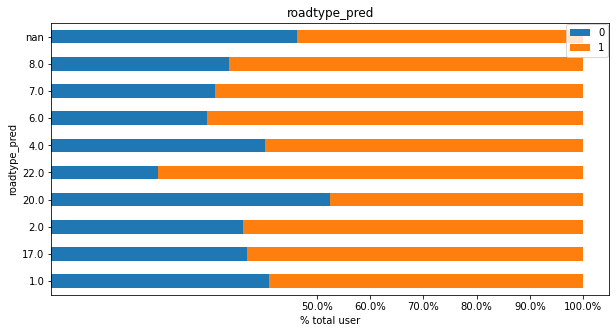

***

### highway_pred

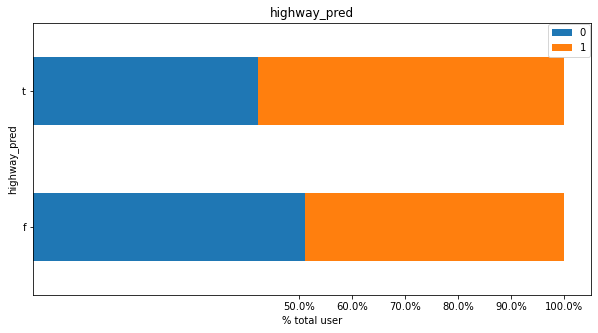

In [20]:
from ia_pkg.plots import stacked_plot, dist_plot
stacked_plot(data[mask_dev],
            cat_columns=cols_pred_cat,
            col_target=col_target)

**Numerical Predictor**

***

### isweekend

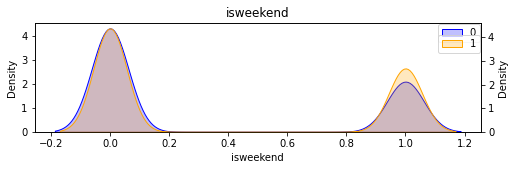

***

### isrushhour

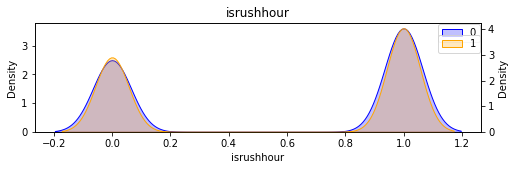

***

### ispayday

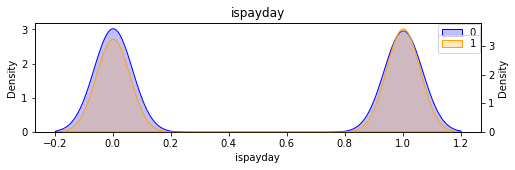

In [21]:
dist_plot(data[mask_dev],
            columns=cols_pred_num,
            col_target=col_target)

## Data Split

- Split data into three parts (train,valid,test)
- Adds a new column indicating to which part the observation belong
- Split is done in random
- Set the random seed so the results are replicable

In [22]:
from ia_pkg.function import data_split

data['data_type'] = 'submit'
split = data_split(data[mask_dev],
                               sample_sizes=[0.8,0.1,0.1],
                               sample_names=['train','test','valid'],
                               seed=42)

data.at[mask_dev, 'data_type'] = split

train    57068
valid     7135
test      7133
dtype: int64


In [23]:
#masked the sample name
train_mask = (data['data_type'] == 'train')
valid_mask = (data['data_type'] == 'valid')
test_mask = (data['data_type'] == 'test')

In [24]:
data['data_type'].value_counts()

train     57068
submit    13841
valid      7135
test       7133
Name: data_type, dtype: int64

In [25]:
data_summary = data[mask_dev].groupby(['data_type']).aggregate({col_target:['sum','count']})
data_summary.columns = [col_target, 'rows']
data_summary[col_target+' rate'] = data_summary[col_target] / data_summary['rows']

display(data_summary)

,target,rows,target rate
data_type,,,
test,4606,7133,0.645731
train,37812,57068,0.662578
valid,4765,7135,0.667835


## Data Transformation

### Categorical - Woe Encoder

WoE method chose to transform the string-type categorical predictor to be in numeric form, WoE estimated the weight of each predictor's unique value for their ability to separate the target(in this case Default/not default).

WoE is also flexible with the null value as we can cluster it into 'special segment'. So the imputation would not be needed in this case.

In [26]:
import category_encoders.woe as ce
# from ia_pkg.function import woe_transform

# #fit and transform WoE on categorical predictor
woe = ce.WOEEncoder(drop_invariant=True)
data_woe = woe.fit(data[train_mask][cols_pred_cat],data[train_mask][col_target]).transform(data[cols_pred_cat])

# data_woe = woe_transform(data,
#                          mask=train_mask,
#                          cat_columns=cols_pred_cat,
#                          col_target=col_target)

In [27]:
#Stored the WoE output on cols_woe
data_woe.columns = [i + '_woe' for i in data_woe.columns]
cols_woe = list(data_woe.columns)

data[cols_woe] = data_woe

In [28]:
woe_change = []
#Listed the tranformation result on each unique value on categorical predictor
for col,col_woe in zip(cols_pred_cat,cols_woe):
    woe_change.append(data[mask_dev][[col,col_woe,col_target]].fillna('Null').groupby([col,col_woe]).agg(
        {col_woe: ['count'],
         col_target : ['sum','mean']}))

for i in range(len(woe_change)):
    woe_change[i]
woe_change[0].columns = [('branch_code_woe count'),
            (   'default_flag count'),
            (   'default_flag rate')]
pd.DataFrame(woe_change[4])

roadtype_pred_woe target          
                                            count    sum      mean
roadtype_pred roadtype_pred_woe                                   
1.0           -0.296075                      5573   3293  0.590885
17.0          -0.310110                        76     48  0.631579
2.0           -0.097626                     25552  16351  0.639911
20.0          -0.702152                       181     86  0.475138
22.0           0.739826                       378    302  0.798942
4.0           -0.290290                      2561   1530  0.597423
6.0            0.205961                     12233   8652  0.707267
7.0            0.142642                     23360  16153  0.691481
8.0            0.113705                        18     12  0.666667
nan           -0.518923                      1404    756  0.538462

### Numerical - Missing Imputation

Missing value imputation is done by filling the mean value to each predictor

In [29]:
try:
    cols_num_missing = data[mask_dev][cols_pred_num].columns[data[mask_dev][cols_pred_num].isnull().any()].tolist()
#filling the missing value with mean
    for c in cols_num_missing:
        mean = data[mask_dev][c].mean()
        data[mask_dev][c+'_imp'] = data[mask_dev][c].fillna(mean,axis=0)
except:
    print('no operation needed')

### Numerical - Standardization

Scaling is done on numerical predictors to avoid the outlier/bigger magnitude value effects on the model. Standardization is one of the methods for scaling, it transformed all the values by centering its mean at 0 then scales the variance at 1. 

The pros of this method is it keeping the shape of the predictor's original distribution

In [30]:
from sklearn.preprocessing import StandardScaler
#listed the imputation and non-imputation predictor for scaling
needed = False

if needed:
    cols_pred_num2 = list(map(lambda x: x+'_imp' if x in cols_num_missing else x, cols_pred_num))       

    scaler = StandardScaler(with_mean=True, with_std=True)
    scaler.fit(data[train_mask][cols_pred_num2])
    # print(scaler.mean_)
    data_sd = scaler.transform(data[train_mask|valid_mask|test_mask][cols_pred_num2])

In [31]:
# stored the standardscaler output on cols_sd
if needed:
    cols_sd = [i+'_sd' for i in cols_pred_num]

    data[cols_sd] = data_sd
    data[cols_sd].head()
    
else: 
    cols_sd=[]

### Wrapped up all the transformed predictor

In [32]:
cols_shortlist = []

for c in cols_sd:
    cols_shortlist.append(c)
for c in cols_woe:
    cols_shortlist.append(c)

display(cols_shortlist)

['daytime_woe',
 'weekofmonth_woe',
 'city_pred_woe',
 'street_pred_woe',
 'roadtype_pred_woe',
 'highway_pred_woe']

# Predictor Selection
<br>

Selecting the best predictor for the model, it applied to all transformed predictors. The selection metrics would be **gini, IV** (Predictive power), and **inter-predictor correlation**

## Predictive power comparison

Calculates IV and Gini of each predictor, sorts the predictors by their power. The power is calculated for each of the samples (train, validate, test).

In [33]:
from ia_pkg.metrics import iv,gini

power_tab = []
for j in range(0,len(cols_shortlist)):
    power_tab.append({'Name':cols_shortlist[j]
                    ,'Gini Train':gini(data.loc[train_mask,col_target],data.loc[train_mask,cols_shortlist[j]])                    
                    ,'Gini Validate':gini(data.loc[valid_mask,col_target],data.loc[valid_mask,cols_shortlist[j]])
                    ,'Gini Test':gini(data.loc[test_mask,col_target],data.loc[test_mask,cols_shortlist[j]])
                    ,'IV Train':iv(data.loc[train_mask,col_target],data.loc[train_mask,cols_shortlist[j]])
                    ,'IV Validate':iv(data.loc[valid_mask,col_target],data.loc[valid_mask,cols_shortlist[j]])
                    ,'IV Test':iv(data.loc[test_mask,col_target],data.loc[test_mask,cols_shortlist[j]])     
                     })
power_out = pd.DataFrame.from_records(power_tab)
power_out = power_out.set_index('Name').abs()
power_out = power_out.sort_values('Gini Validate',ascending=False)

pd.options.display.max_rows = 1000
display(power_out)
pd.options.display.max_rows = 30

,Gini Train,Gini Validate,Gini Test,IV Train,IV Validate,IV Test
Name,,,,,,
street_pred_woe,0.370362,0.323625,0.324722,0.629452,0.676063,0.651510
daytime_woe,0.117880,0.127386,0.136243,0.072965,0.065387,0.090110
city_pred_woe,0.120695,0.106073,0.099249,0.050184,0.053329,0.044059
roadtype_pred_woe,0.101046,0.105736,0.093149,0.036937,0.042622,0.034005
weekofmonth_woe,0.044739,0.066529,0.044396,0.011284,0.019083,0.010311
highway_pred_woe,0.010741,0.013815,0.008766,0.006631,0.008729,0.003956


## Correlations

Show correlation matrix of all predictor

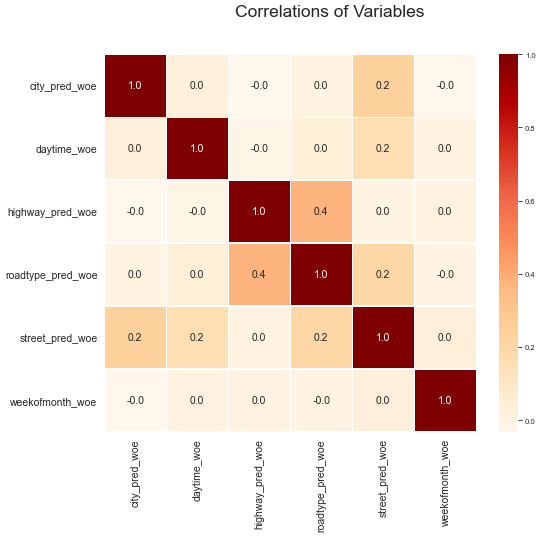

In [34]:
cormat = data[sorted(cols_shortlist)].corr()

plt.rcParams.update({'font.size': 15})
sns.set()
%matplotlib inline
%config InlineBackend.close_figures=True

fig, ax = plt.subplots(figsize=(12,10), dpi=50)
fig.suptitle('Correlations of Variables',fontsize=25)
sns.heatmap(cormat, ax=ax, annot=True, fmt="0.1f", linewidths=.5, annot_kws={"size":15},cmap="OrRd")
plt.tick_params(labelsize=15)
plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.show()
plt.clf();plt.close()

In [35]:
max_ok_correlation = 0.5

# find highest pairwise correlation (correlation greater than .. in absolute value)
hicors = []
for i in range(0,len(cormat)):
    for j in range(0,len(cormat)):
        if ((cormat.iloc[i][j] > max_ok_correlation or cormat.iloc[i][j] < -max_ok_correlation) and i < j):
            hicors.append((i,j,cormat.index[i],cormat.index[j],cormat.iloc[i][j],abs(cormat.iloc[i][j])))
hicors.sort(key= lambda x: x[5], reverse=True)

hicors2 = pd.DataFrame(list(zip(*list(zip(*hicors))[2:5])), columns = ['predictor_1', 'predictor_2', 'corr'])

# print list of highest correlations
hicors2

,predictor_1,predictor_2,corr


Combining output set from these selection methods, we choosing the predictor which placed on top individual predictive power and eliminate which both ranked on bottom(low gini) and having inter-predictor correlation (>0.5)


This new predictor set expected can prevent the low quality and mulitcollinearity issue that may occur on the model(e.g. Logistic Regression)

# Modeling

## XGBoost Session

Needs xgboost library to be installed.

First we train a gradient boosting model using a "standard" set of hyperparameters.

In [36]:
pred_xgb = cols_pred_num + [c + '_woe' for c in cols_pred_cat]

### Train initial model

In [37]:
from ia_pkg.metrics import gini
import xgboost as xgb
# pred_xgb.remove('delinquency_score')
dt_xgb = data[pred_xgb]

xgb_params = {'eta': 0.1,
  'max_depth': 3,
  'objective': 'binary:logistic',
  'eval_metric': 'auc',
  'min_child_weight': 30,
  'subsample': 0.85}

evals_result = {}

ibooster= xgb.train(params= xgb_params,
                        dtrain= xgb.DMatrix(dt_xgb[train_mask],data[train_mask][col_target]),
                        num_boost_round= 200,
                        early_stopping_rounds = 20,
                        evals= ((xgb.DMatrix(dt_xgb[train_mask],data[train_mask][col_target]),'train'),
                                 (xgb.DMatrix(dt_xgb[valid_mask],data[valid_mask][col_target]),'valid')
                                ), 
                        evals_result= evals_result,)

ixgb_scored= ibooster.predict(xgb.DMatrix(dt_xgb), ntree_limit=ibooster.best_ntree_limit)

[0]	train-auc:0.675794	valid-auc:0.647776
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 20 rounds.
[1]	train-auc:0.679641	valid-auc:0.655299
[2]	train-auc:0.683475	valid-auc:0.659725
[3]	train-auc:0.684851	valid-auc:0.659695
[4]	train-auc:0.685767	valid-auc:0.660672
[5]	train-auc:0.686346	valid-auc:0.660929
[6]	train-auc:0.686392	valid-auc:0.660887
[7]	train-auc:0.686461	valid-auc:0.662545
[8]	train-auc:0.687169	valid-auc:0.661801
[9]	train-auc:0.688321	valid-auc:0.662765
[10]	train-auc:0.688363	valid-auc:0.662854
[11]	train-auc:0.688948	valid-auc:0.663944
[12]	train-auc:0.689022	valid-auc:0.663908
[13]	train-auc:0.689239	valid-auc:0.66401
[14]	train-auc:0.689963	valid-auc:0.664608
[15]	train-auc:0.69055	valid-auc:0.665378
[16]	train-auc:0.690592	valid-auc:0.665463
[17]	train-auc:0.690603	valid-auc:0.665536
[18]	train-auc:0.69091	valid-auc:0.665686
[19]	train-auc:0.69118	valid-auc:0.665616
[20]	train-

[187]	train-auc:0.708517	valid-auc:0.679272
[188]	train-auc:0.708571	valid-auc:0.679172
[189]	train-auc:0.7086	valid-auc:0.679261
[190]	train-auc:0.708606	valid-auc:0.679267
[191]	train-auc:0.708689	valid-auc:0.679346
[192]	train-auc:0.708748	valid-auc:0.679379
[193]	train-auc:0.708817	valid-auc:0.679475
[194]	train-auc:0.708866	valid-auc:0.679601
[195]	train-auc:0.708921	valid-auc:0.679578
[196]	train-auc:0.708996	valid-auc:0.679621
[197]	train-auc:0.709006	valid-auc:0.679646
[198]	train-auc:0.70909	valid-auc:0.67975
[199]	train-auc:0.70917	valid-auc:0.679826


In [38]:
print('     Train gini:',gini(data[train_mask][col_target], ixgb_scored[train_mask]))
print('Validation gini:',gini(data[valid_mask][col_target], ixgb_scored[valid_mask]))

     Train gini: 0.4183398102307567
Validation gini: 0.3596529724033808


### Evaluate predictor

Predictors evaluated due to their sorted importances on two metrics (weight and gain). At first, we can set the number of predictors which we want to see

In [39]:
n_top = 10 #how many best predictors I want to see

#### Weight of each predictor

Select *n_top* predictors with highest weight (i.e. those which were in most trees)

In [40]:
pred_xgb_wgh = [x[0] for x in sorted([(k, v) for k, v in ibooster.get_score(importance_type = 'weight').items()]\
                                     , key=lambda x:x[1], reverse = True)]
if len(pred_xgb_wgh) > n_top:
    pred_xgb_wgh = pred_xgb_wgh[:n_top]

#### Gain of each predictor

Select *n_top* predictors with highest gain (i.e. relative contribution of the corresponding feature to the model calculated by taking each feature’s contribution for each tree in the model)

In [41]:
pred_xgb_gain = [x[0] for x in sorted([(k, v) for k, v in ibooster.get_score(importance_type = 'gain').items()]\
                                      , key=lambda x:x[1], reverse = True)]
if len(pred_xgb_gain) > n_top:
    pred_xgb_gain = pred_xgb_gain[:n_top]

#### Selected Predictor

Select the final predictors as we combining (union or intersection) the output from each metrics

In [42]:
def union(lst1, lst2):
    final_list  = list(set(lst1) | set(lst2))
    return final_list

def intersect(lst1, lst2):
    final_list = list(set(lst1) & set(lst2))
    return final_list

In [43]:
pred_xgb = union(pred_xgb_wgh, pred_xgb_gain)
display(pred_xgb)

['roadtype_pred_woe',
 'weekofmonth_woe',
 'city_pred_woe',
 'highway_pred_woe',
 'daytime_woe',
 'isweekend',
 'street_pred_woe',
 'ispayday',
 'isrushhour']

In [61]:
pred_xgb = ['isrushhour',
#  'street_pred_woe',
 'isweekend',
 'ispayday',
 'city_pred_woe',
 'daytime_woe',
 'weekofmonth_woe',
 'roadtype_pred_woe',
 'highway_pred_woe']

### Tuning parameter

Hyperparameter tuning applied to two inputs (max_depth and learning rate).
Tuning set then will be evaluated on the valid sample.

There are two options on the best estimation to choose from.

*best_valid* for tuning set that has best gini on valid sample

*best_diff* for tuning set that has train-valid lowest gini difference

In [62]:
from ia_pkg.metrics import gini

import xgboost as xgb

dt_xgb = data[pred_xgb]

col_result = ['eta', 'max_depth', 'gini_train', 'gini_valid', 'difference']
result = pd.DataFrame(columns = col_result)
grid_params = {
            'eta' : [0.1,0.2,0.3],
            'max_depth' : [2,3,4]
#               'min_child_weight' : [10,20,30,40,50],
#               'subsample' : [0.5, 0.6, 0.7, 0.8, 0.9]      
}

flag = False

for eta in grid_params['eta']:
    for max_depth in grid_params['max_depth']:
        xgb_params = {'eta': eta,
                            'max_depth': max_depth,
                            'objective': 'binary:logistic',
                            'eval_metric': 'auc',
                            'min_child_weight': 30,
                            'subsample': 0.85}

        evals_result = {}

        tbooster = xgb.train(params = xgb_params,
                                    dtrain = xgb.DMatrix(dt_xgb[train_mask],data[train_mask][col_target]),
                                    num_boost_round = 200,
                                    early_stopping_rounds = 20,
                                    evals = ((xgb.DMatrix(dt_xgb[train_mask],data[train_mask][col_target]),'train'),
                                             (xgb.DMatrix(dt_xgb[valid_mask],data[valid_mask][col_target]),'valid')
                                            ), 
                                    evals_result = evals_result,)

        txgb_scored = tbooster.predict(xgb.DMatrix(dt_xgb), ntree_limit=tbooster.best_ntree_limit)
        gini_train = gini(data[train_mask][col_target], txgb_scored[train_mask])
        gini_valid = gini(data[valid_mask][col_target], txgb_scored[valid_mask])
        added = [eta, max_depth, gini_train, gini_valid, (gini_train-gini_valid)]
        if flag == False:
            result = pd.DataFrame([added], columns = col_result)
            flag = True
        else:
            result = pd.concat([result, pd.DataFrame([added], columns = col_result)], axis=0)

[0]	train-auc:0.572038	valid-auc:0.57047
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 20 rounds.
[1]	train-auc:0.572047	valid-auc:0.570503
[2]	train-auc:0.572047	valid-auc:0.570503
[3]	train-auc:0.595128	valid-auc:0.588522
[4]	train-auc:0.597697	valid-auc:0.597084
[5]	train-auc:0.599509	valid-auc:0.595118
[6]	train-auc:0.599481	valid-auc:0.595136
[7]	train-auc:0.602091	valid-auc:0.593949
[8]	train-auc:0.602281	valid-auc:0.597044
[9]	train-auc:0.603085	valid-auc:0.595534
[10]	train-auc:0.603169	valid-auc:0.595636
[11]	train-auc:0.60808	valid-auc:0.601333
[12]	train-auc:0.608204	valid-auc:0.601466
[13]	train-auc:0.60973	valid-auc:0.606009
[14]	train-auc:0.612037	valid-auc:0.607688
[15]	train-auc:0.612203	valid-auc:0.60744
[16]	train-auc:0.612395	valid-auc:0.606936
[17]	train-auc:0.613891	valid-auc:0.608466
[18]	train-auc:0.613877	valid-auc:0.609077
[19]	train-auc:0.614424	valid-auc:0.609268
[20]	train-

[187]	train-auc:0.635356	valid-auc:0.629467
[188]	train-auc:0.635465	valid-auc:0.629453
[189]	train-auc:0.635518	valid-auc:0.629467
[190]	train-auc:0.63548	valid-auc:0.629516
[191]	train-auc:0.635573	valid-auc:0.629677
[192]	train-auc:0.635602	valid-auc:0.629677
[193]	train-auc:0.635598	valid-auc:0.629725
[194]	train-auc:0.635634	valid-auc:0.630002
[195]	train-auc:0.635618	valid-auc:0.629899
[196]	train-auc:0.63566	valid-auc:0.629956
[197]	train-auc:0.635629	valid-auc:0.629923
[198]	train-auc:0.635655	valid-auc:0.630092
[199]	train-auc:0.635695	valid-auc:0.630137
[0]	train-auc:0.589469	valid-auc:0.589303
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 20 rounds.
[1]	train-auc:0.599913	valid-auc:0.596012
[2]	train-auc:0.60071	valid-auc:0.596893
[3]	train-auc:0.604877	valid-auc:0.601879
[4]	train-auc:0.60567	valid-auc:0.601965
[5]	train-auc:0.606078	valid-auc:0.599182
[6]	train-auc:0.606351	valid-auc:0.59

[174]	train-auc:0.646509	valid-auc:0.635363
[175]	train-auc:0.646549	valid-auc:0.63533
[176]	train-auc:0.646631	valid-auc:0.635302
[177]	train-auc:0.646663	valid-auc:0.635247
[178]	train-auc:0.646708	valid-auc:0.635228
[179]	train-auc:0.646733	valid-auc:0.635167
[180]	train-auc:0.646735	valid-auc:0.635209
[181]	train-auc:0.646756	valid-auc:0.635093
[182]	train-auc:0.646804	valid-auc:0.6351
[183]	train-auc:0.646968	valid-auc:0.635017
[184]	train-auc:0.647034	valid-auc:0.635075
[185]	train-auc:0.647088	valid-auc:0.635193
[186]	train-auc:0.647114	valid-auc:0.635129
[187]	train-auc:0.647166	valid-auc:0.635156
[188]	train-auc:0.647246	valid-auc:0.635144
[189]	train-auc:0.647289	valid-auc:0.635189
[190]	train-auc:0.647304	valid-auc:0.635228
[191]	train-auc:0.647322	valid-auc:0.635246
[192]	train-auc:0.647325	valid-auc:0.6352
Stopping. Best iteration:
[172]	train-auc:0.646481	valid-auc:0.635401

[0]	train-auc:0.601635	valid-auc:0.602214
Multiple eval metrics have been passed: 'valid-auc' will

[22]	train-auc:0.620937	valid-auc:0.617528
[23]	train-auc:0.62096	valid-auc:0.617621
[24]	train-auc:0.621405	valid-auc:0.618486
[25]	train-auc:0.623115	valid-auc:0.61883
[26]	train-auc:0.623412	valid-auc:0.619096
[27]	train-auc:0.623448	valid-auc:0.619535
[28]	train-auc:0.623614	valid-auc:0.619898
[29]	train-auc:0.623495	valid-auc:0.619845
[30]	train-auc:0.623615	valid-auc:0.619789
[31]	train-auc:0.62408	valid-auc:0.620738
[32]	train-auc:0.624189	valid-auc:0.620767
[33]	train-auc:0.624477	valid-auc:0.621441
[34]	train-auc:0.624859	valid-auc:0.621471
[35]	train-auc:0.625143	valid-auc:0.621468
[36]	train-auc:0.625383	valid-auc:0.621638
[37]	train-auc:0.626123	valid-auc:0.622109
[38]	train-auc:0.626229	valid-auc:0.622141
[39]	train-auc:0.626379	valid-auc:0.622444
[40]	train-auc:0.626433	valid-auc:0.622515
[41]	train-auc:0.626449	valid-auc:0.622549
[42]	train-auc:0.627285	valid-auc:0.622552
[43]	train-auc:0.62757	valid-auc:0.623147
[44]	train-auc:0.628511	valid-auc:0.623558
[45]	train-auc:

[65]	train-auc:0.644217	valid-auc:0.633234
[66]	train-auc:0.644265	valid-auc:0.633274
[67]	train-auc:0.644431	valid-auc:0.63339
[68]	train-auc:0.644754	valid-auc:0.633789
[69]	train-auc:0.644749	valid-auc:0.633714
[70]	train-auc:0.644973	valid-auc:0.633689
[71]	train-auc:0.645139	valid-auc:0.633528
[72]	train-auc:0.645364	valid-auc:0.633573
[73]	train-auc:0.645507	valid-auc:0.633849
[74]	train-auc:0.645685	valid-auc:0.633825
[75]	train-auc:0.645747	valid-auc:0.634011
[76]	train-auc:0.645807	valid-auc:0.633991
[77]	train-auc:0.645849	valid-auc:0.634071
[78]	train-auc:0.646021	valid-auc:0.633874
[79]	train-auc:0.646088	valid-auc:0.633944
[80]	train-auc:0.646077	valid-auc:0.634008
[81]	train-auc:0.646244	valid-auc:0.633899
[82]	train-auc:0.646324	valid-auc:0.63375
[83]	train-auc:0.646294	valid-auc:0.633607
[84]	train-auc:0.646352	valid-auc:0.633736
[85]	train-auc:0.646406	valid-auc:0.633816
[86]	train-auc:0.646489	valid-auc:0.63383
[87]	train-auc:0.6465	valid-auc:0.633971
[88]	train-auc:0

Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 20 rounds.
[1]	train-auc:0.595308	valid-auc:0.588537
[2]	train-auc:0.595214	valid-auc:0.588569
[3]	train-auc:0.599401	valid-auc:0.588284
[4]	train-auc:0.6044	valid-auc:0.597158
[5]	train-auc:0.607718	valid-auc:0.600827
[6]	train-auc:0.617405	valid-auc:0.607542
[7]	train-auc:0.619317	valid-auc:0.610668
[8]	train-auc:0.617157	valid-auc:0.609301
[9]	train-auc:0.619192	valid-auc:0.611877
[10]	train-auc:0.620095	valid-auc:0.61365
[11]	train-auc:0.619846	valid-auc:0.615797
[12]	train-auc:0.620379	valid-auc:0.61565
[13]	train-auc:0.623645	valid-auc:0.618744
[14]	train-auc:0.624163	valid-auc:0.619082
[15]	train-auc:0.625125	valid-auc:0.619356
[16]	train-auc:0.626826	valid-auc:0.620737
[17]	train-auc:0.627528	valid-auc:0.621376
[18]	train-auc:0.62772	valid-auc:0.621821
[19]	train-auc:0.627394	valid-auc:0.621592
[20]	train-auc:0.627924	valid-auc:0.622114
[21]	train-

[62]	train-auc:0.646997	valid-auc:0.634478
[63]	train-auc:0.647156	valid-auc:0.634633
[64]	train-auc:0.647253	valid-auc:0.634893
[65]	train-auc:0.647245	valid-auc:0.634612
[66]	train-auc:0.647428	valid-auc:0.634825
[67]	train-auc:0.647335	valid-auc:0.634883
[68]	train-auc:0.647597	valid-auc:0.635121
[69]	train-auc:0.647689	valid-auc:0.634915
[70]	train-auc:0.647778	valid-auc:0.634706
[71]	train-auc:0.647943	valid-auc:0.634603
[72]	train-auc:0.647994	valid-auc:0.634714
[73]	train-auc:0.648162	valid-auc:0.634738
[74]	train-auc:0.648387	valid-auc:0.634621
[75]	train-auc:0.648407	valid-auc:0.634685
[76]	train-auc:0.648467	valid-auc:0.634807
[77]	train-auc:0.648598	valid-auc:0.635178
[78]	train-auc:0.648665	valid-auc:0.634941
[79]	train-auc:0.648631	valid-auc:0.634425
[80]	train-auc:0.648706	valid-auc:0.634358
[81]	train-auc:0.64873	valid-auc:0.634597
[82]	train-auc:0.64887	valid-auc:0.634453
[83]	train-auc:0.648848	valid-auc:0.634469
[84]	train-auc:0.648901	valid-auc:0.634608
[85]	train-au

In [63]:
display(result)

,eta,max_depth,gini_train,gini_valid,difference
0,0.1,2,0.271391,0.260274,0.011116
0,0.1,3,0.292962,0.270802,0.022161
0,0.1,4,0.303562,0.273473,0.030089
0,0.2,2,0.273521,0.261905,0.011616
0,0.2,3,0.297694,0.270176,0.027518
0,0.2,4,0.309798,0.271444,0.038354
0,0.3,2,0.276391,0.265927,0.010465
0,0.3,3,0.297195,0.270356,0.026839
0,0.3,4,0.312532,0.274024,0.038508


In [64]:
best_valid = result.loc[result['gini_valid'] == result['gini_valid'].max(),['eta', 'max_depth']].to_dict('list')
best_diff = result.loc[result['difference'] == result['difference'].min(),['eta', 'max_depth']].to_dict('list')

print('hyperparameter for best_valid: ', best_valid)
print('hyperparameter for best_diff, ', best_diff)

hyperparameter for best_valid:  {'eta': [0.3], 'max_depth': [4]}
hyperparameter for best_diff,  {'eta': [0.3], 'max_depth': [2]}


### Final Model

In [65]:
import xgboost as xgb

dt_xgb = data[pred_xgb]
# tuning = best_diff # set hyperparameter

xgb_params = {'eta': 0.2,
    'max_depth': 3,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'min_child_weight': 30,
    'subsample': 0.85}

evals_result = {}

booster = xgb.train(params = xgb_params,
                        dtrain = xgb.DMatrix(dt_xgb[train_mask],data[train_mask][col_target]),
                        num_boost_round = 500,
                        early_stopping_rounds = 20,
                        evals = ((xgb.DMatrix(dt_xgb[train_mask],data[train_mask][col_target]),'train'),
                                 (xgb.DMatrix(dt_xgb[valid_mask],data[valid_mask][col_target]),'valid')
                                ), 
                        evals_result = evals_result,)

xgb_scored = booster.predict(xgb.DMatrix(dt_xgb), ntree_limit=booster.best_ntree_limit)

[0]	train-auc:0.589469	valid-auc:0.589303
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 20 rounds.
[1]	train-auc:0.600722	valid-auc:0.596879
[2]	train-auc:0.60586	valid-auc:0.599293
[3]	train-auc:0.605641	valid-auc:0.598403
[4]	train-auc:0.611125	valid-auc:0.603418
[5]	train-auc:0.621081	valid-auc:0.614354
[6]	train-auc:0.621021	valid-auc:0.614083
[7]	train-auc:0.622271	valid-auc:0.615104
[8]	train-auc:0.623056	valid-auc:0.61643
[9]	train-auc:0.629384	valid-auc:0.622227
[10]	train-auc:0.629882	valid-auc:0.622544
[11]	train-auc:0.630004	valid-auc:0.623291
[12]	train-auc:0.631237	valid-auc:0.623389
[13]	train-auc:0.631306	valid-auc:0.623683
[14]	train-auc:0.631727	valid-auc:0.624235
[15]	train-auc:0.632003	valid-auc:0.624494
[16]	train-auc:0.633285	valid-auc:0.624675
[17]	train-auc:0.63361	valid-auc:0.624219
[18]	train-auc:0.633781	valid-auc:0.624046
[19]	train-auc:0.633909	valid-auc:0.624432
[20]	train

### Evaluate final model

In [66]:
print('     Train gini:',gini(data[train_mask][col_target], xgb_scored[train_mask]))
print('Validation gini:',gini(data[valid_mask][col_target], xgb_scored[valid_mask]))

     Train gini: 0.29769409360265775
Validation gini: 0.2701756389992074


#### Gain Importance

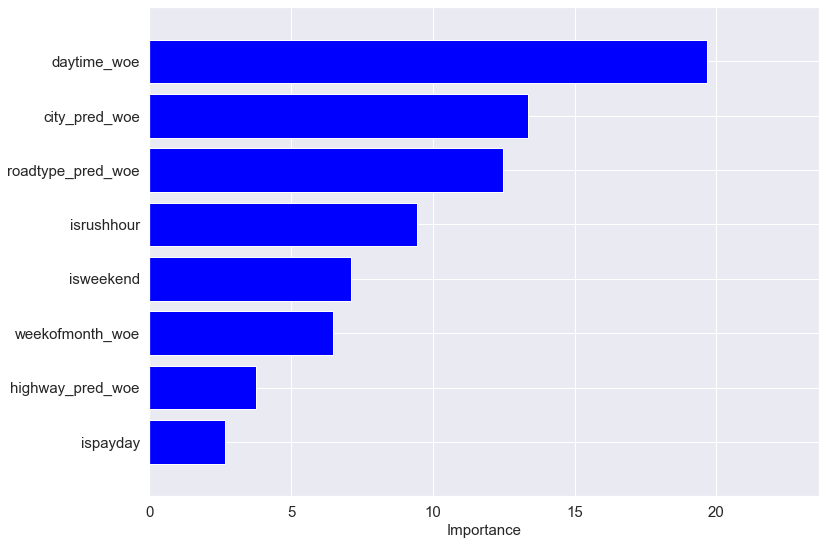

In [67]:
fs = booster.get_score(importance_type = 'gain') # available importance types: 'gain', 'cover', 'weight'
imp = sorted([(k, v) for k, v in fs.items()], key = lambda x:x[1], reverse = True)
imp.reverse()

fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111)
ax.barh(range(len(imp)), [v for k, v in imp], color="blue",  align='center')
plt.yticks(range(len(imp)), [k for k, v in imp], fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel('Importance',fontsize=15)
plt.ylim([-1, len(imp)])
plt.xlim([0, max([v for k, v in imp])*1.2])
plt.show()

# Score the dataset

Create a new column with the prediction (probability of default).

In [68]:
col_score = 'XGB_SCORE'

data[col_score] = xgb_scored
print('Column',col_score,'with the prediction added/modified. Number of columns:',data.shape[1])

Column XGB_SCORE with the prediction added/modified. Number of columns: 20


# Performance characteristics
Performance characteristics of the models (Gini, Lift, KS) and their visualisations.

In [69]:
from ia_pkg.metrics import gini, lift, kolmogorov_smirnov
lift_perc = 10

## Performance per sample

In [70]:
perf = pd.DataFrame({'sample':[
    'train',
    'valid',
    'test'    
    ], 'XGB_gini':[
    gini(data[train_mask][col_target],data[train_mask][col_score]) #train
    ,gini(data[valid_mask][col_target],data[valid_mask][col_score]) #valid
    ,gini(data[test_mask][col_target],data[test_mask][col_score]) #test
    ], 'XGB_lift'+str(lift_perc):[
    lift(data[train_mask][col_target],-data[train_mask][col_score],lift_perc) #train
    ,lift(data[valid_mask][col_target],-data[valid_mask][col_score],lift_perc) #valid
    ,lift(data[test_mask][col_target],-data[test_mask][col_score],lift_perc) #test
    ], 'XGB_KS':[
    kolmogorov_smirnov(data[train_mask][col_score],data[train_mask][col_target]) #train
    ,kolmogorov_smirnov(data[valid_mask][col_score],data[valid_mask][col_target]) #valid
    ,kolmogorov_smirnov(data[test_mask][col_score],data[test_mask][col_target]) #test
    ]}).set_index('sample')

In [71]:
display(perf)

,XGB_gini,XGB_lift10,XGB_KS
sample,,,
train,0.297694,1.220511,0.214028
valid,0.270176,1.209187,0.194738
test,0.264462,1.194230,0.195299


## F1 score on default threshold

In [72]:
score = f1_score(data[test_mask][col_target], np.where(data[test_mask][col_score]>=0.5,1,0))
print('F-Score: %.5f' % score)

F-Score: 0.79249


## ROC Curve

Best Threshold=0.675732, G-Mean=0.591


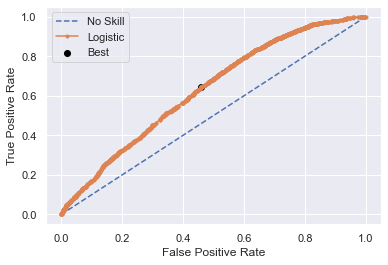

In [73]:
# calculate roc curves
fpr, tpr, th = roc_curve(data[test_mask][col_target], 
                                 data[test_mask][col_score])
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))

# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (th[ix], gmeans[ix]))

# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

## Score Linearity on Holdout Sample

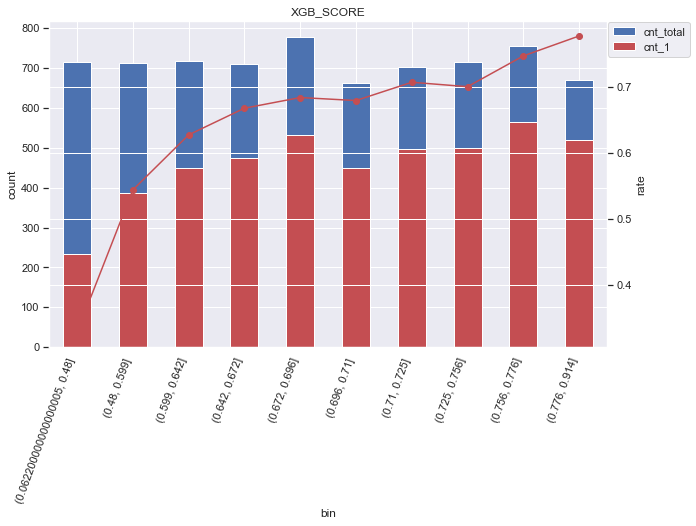

In [74]:
from ia_pkg.plots import plot_score_linearity
plot_score_linearity(data[test_mask],
                    col_score=col_score,
                    col_target=col_target,
                    bins=10)

##  Simulating threshold for best F1

In [79]:
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

# define thresholds
thresholds = arange(0, 1, 0.001)
# evaluate each threshold
scores = [f1_score(data[test_mask][col_target], to_labels(data[test_mask][col_score], t)) for t in thresholds]
# get best threshold
ix = argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.455, F-Score=0.79633


# Save Submit

In [80]:
# save dataset
submit = np.where(data[mask_submit][col_score] > thresholds[ix], True,False)
data.at[mask_submit, 'Labels'] = submit
data[mask_submit]['Labels'].to_csv('2_dsi_pred.csv')

In [81]:
data[mask_submit]['Labels'].head()

Ids
2e6992a84_2020-11-25_18    True
2e68e62f4_2020-11-29_20    True
2e68e81a4_2020-11-27_10    True
2e69eec04_2020-11-24_7     True
2e698e4a4_2020-11-27_8     True
Name: Labels, dtype: object

In [82]:
data[mask_submit]['Labels'].value_counts()

True     11690
False     2151
Name: Labels, dtype: int64